In [125]:
import tp3
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd
from faker import Faker
import time
from joblib import dump, load
import sys 
import os 
from tp3 import aprox_hs_by_greedy

In [126]:
NAME_SIZE = 39
SUBSETS_SIZE = 200

In [127]:
#Library to ganerate ramdon team players 

def generate_fake_names():
    fake = Faker()
    random_names = set()
    random_names_list  = []
    while len(random_names) < NAME_SIZE:
        nombre = fake.name()
        random_names.add(nombre)

    random_names_list = list(random_names)
    return random_names, random_names_list

def generate_substsets(random_names):
    subsets = []
    for i in range(SUBSETS_SIZE): 
        subset = []
        for _ in range(i): 
            new_set = set()
            for k in range(random.randint(1, NAME_SIZE)):
                pos = random.randint(1, NAME_SIZE - 1)
                new_set.add(random_names[pos])
            subset.append(new_set)
        subsets.append(subset)
    return subsets

def generate_substsets_vol(random_names):
    subsets = []
    for i in range(SUBSETS_SIZE): 
        subset = []
        for _ in range(i): 
            new_set = set()
            for k in range(len(random_names)//7):
                pos = random.randint(1, NAME_SIZE - 1)
                new_set.add(random_names[pos])
            subset.append(new_set)
        subsets.append(subset)
    return subsets


def calculate_times(subsets, bt_func, lp_func, a):    
    time_list_bt = []  
    time_list_lp = []
    lengths = []    
    opts = []
    for i in range(len(subsets)):
        time_bt = 0
        time_lp = 0
        opt = 0
        for _ in range(5):
            bt_time_i = time.time()
            bt_sol = bt_func(subsets[i], a)
            bt_time_e = time.time()
            elapsed_time_bt = bt_time_e - bt_time_i

            lp_time_i = time.time()
            lp_sol = lp_func(subsets[i], a)
            lp_time_e = time.time()
            elapsed_time_lp = lp_time_e - lp_time_i
            
            if (len(bt_sol) != len(lp_sol)):
                continue
            time_bt += elapsed_time_bt
            time_lp += elapsed_time_lp
            opt = len(bt_sol)  
        if (time_bt == 0):
            continue
        time_list_bt.append(time_bt/5)
        time_list_lp.append(time_lp/5)
        lengths.append(len(subsets[i]))
        opts.append(opt)
    return time_list_bt, time_list_lp, lengths, opts


def calculate_aprox_times(subsets, greedy_aprox, lpc_aprox, a, filter):
    greedy = []  
    lpc = []    
    aprox_by_greedy = []
    aprox_by_clp = []
    for i in filter:
        greedy_time = 0
        lcp_time = 0
        opt_greedy = 0
        opt_lpc = 0
        for _ in range(10):
            bt_time_i = time.time()
            greedy_sol = greedy_aprox(subsets[i], a)
            bt_time_e = time.time()
            opt_greedy += len(greedy_sol)
            greedy_time = bt_time_e - bt_time_i

            lp_time_i = time.time()
            lpc_sol = lpc_aprox(subsets[i], a)
            lp_time_e = time.time()
            opt_lpc += len(lpc_sol)
            lcp_time += lp_time_e - lp_time_i
        greedy.append(greedy_time/10)
        lpc.append(lcp_time/10)
        aprox_by_greedy.append(opt_greedy//10)
        aprox_by_clp.append(opt_lpc//10)
    return greedy, lpc, aprox_by_greedy, aprox_by_clp



def generate_teorical_time(lengths, base):
    teorical_time = []
    for n in lengths:
        teorical_time.append( (base)**n)
        
    return teorical_time

In [128]:
if not os.path.exists("randomizedData/fake_names.plk") or not os.path.exists("randomizedData/subsets.plk"):
    fake_names, fake_name_list = generate_fake_names()
    subsets = generate_substsets(fake_name_list)
    dump(fake_names, "randomizedData/fake_names.plk")
    dump(subsets, "randomizedData/subsets.plk")
else: 
    fake_names = load("randomizedData/fake_names.plk")
    subsets = load("randomizedData/subsets.plk")

In [129]:
if not os.path.exists("randomizedData/times.csv"):
    bt_time, lp_time, lengths, opts = calculate_times(subsets, tp3.search_for_min_hitting_set, tp3.search_hs_linealp, fake_names)
    times = pd.DataFrame({'m': lengths, 'bt_time': bt_time, 'ilp_time': lp_time, 'opt': opts})
    greedy, lpc,aprox_by_greedy, aprox_by_clp = calculate_aprox_times(subsets, tp3.aprox_hs_by_greedy, tp3.aprox_hs_by_contlp, fake_names, times['m'])
    times['greed_t'] = greedy
    times['lpc_t'] = lpc
    times['opt_greedy'] = aprox_by_greedy
    times['opt_clp'] = aprox_by_clp
    times.to_csv('randomizedData/times.csv', index=False)
else: 
    times = pd.read_csv('randomizedData/times.csv')

Text(0.5, 0, 'Cantidad de conjuntos')

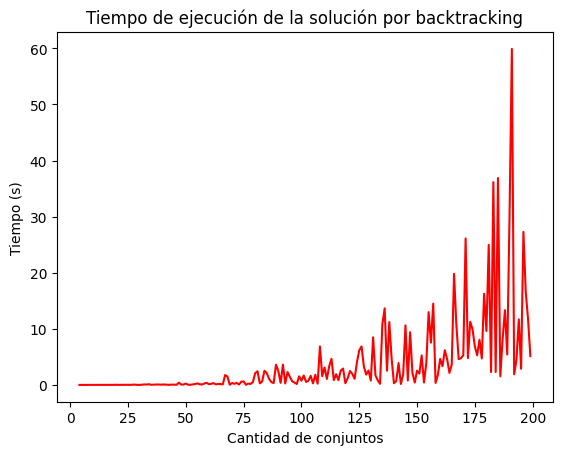

In [130]:
plt.plot(times['m'], times['bt_time'], label='linealp', color='red')
plt.title('Tiempo de ejecución de la solución por backtracking')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')

Text(0.5, 0, 'Cantidad de conjuntos')

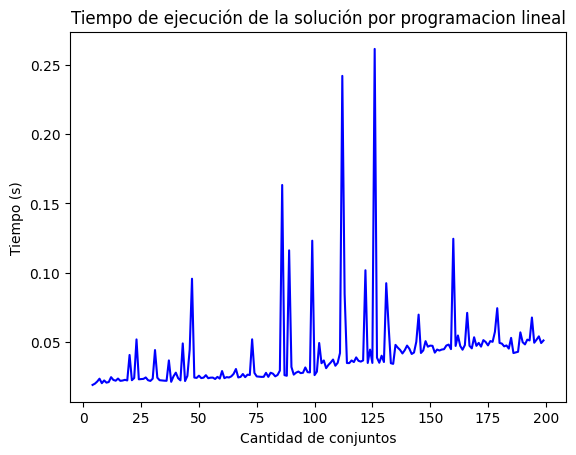

In [131]:
plt.plot(times['m'], times['ilp_time'], label='linealp', color='blue')
plt.title('Tiempo de ejecución de la solución por programacion lineal')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')

Text(0.5, 0, 'Cantidad de conjuntos')

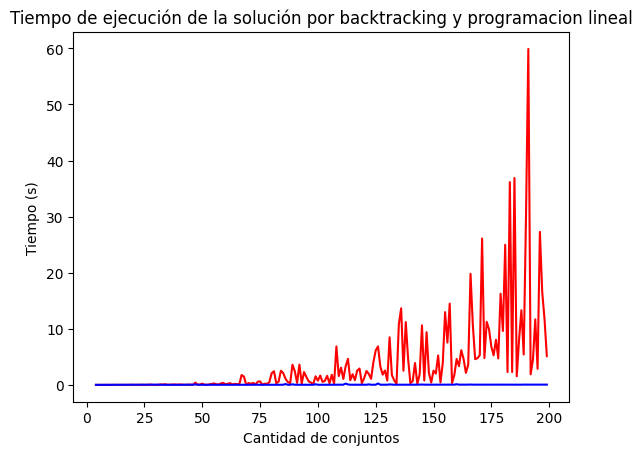

In [132]:
plt.plot(times['m'], times['bt_time'], label='backtracking', color='red')
plt.plot(times['m'], times['ilp_time'], label='linealp', color='blue')
plt.title('Tiempo de ejecución de la solución por backtracking y programacion lineal')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')

Text(0.5, 0, 'Cantidad de conjuntos')

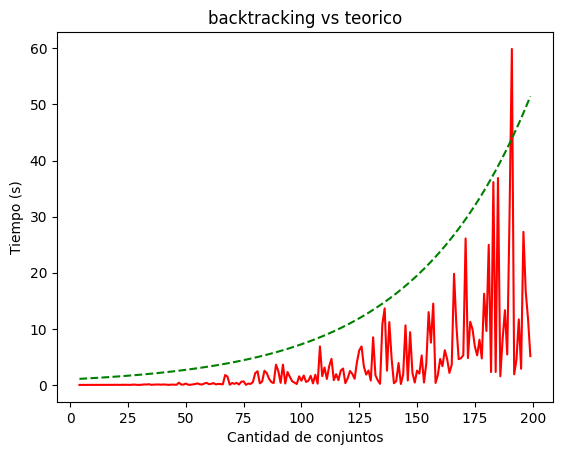

In [133]:
plt.plot(times['m'], times['bt_time'], label='backtracking', color='red')
plt.plot(times['m'], generate_teorical_time(times['m'], 1.02), label='teorico', color='green', linestyle='dashed')
plt.title('backtracking vs teorico')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')

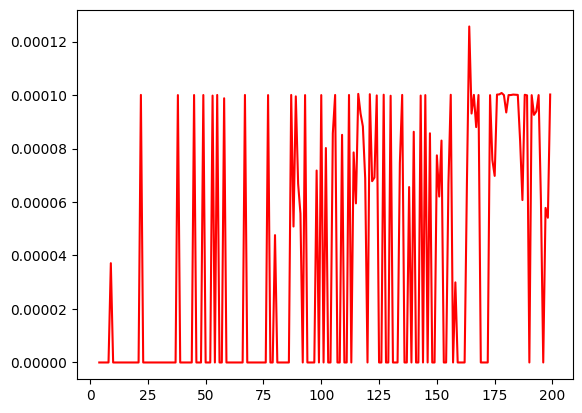

In [134]:
plt.plot(times['m'], times['greed_t'], label='backtracking', color='red')

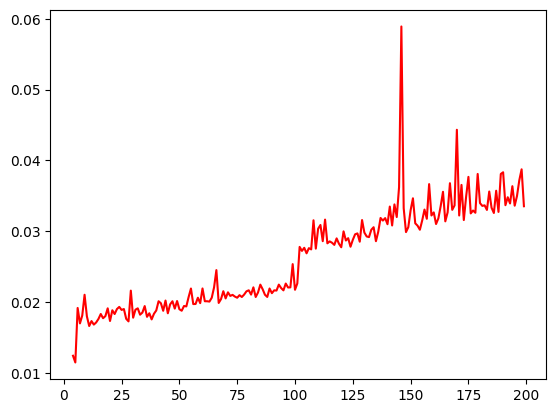

In [135]:
plt.plot(times['m'], times['lpc_t'], label='backtracking', color='red')

In [ ]:
plt.plot(times['m'], times['greed_opt'], label='greedy', color='red')
plt.plot(times['m'], times['opt'], label='bt/pl', color='blue')
plt.plot(times['m'], times['opt_greedy'], label='greedy', color='green')

In [140]:
NAME_SIZE = 1000
SUBSETS_SIZE = 3000

In [141]:
fake_names_aprox, fake_name_list_prox = generate_fake_names()
dump(fake_name_list_prox, "randomizedData/fake_names_aprox.plk")

['randomizedData/fake_names_aprox.plk']

In [143]:
subsets_aprox = generate_substsets_vol(fake_name_list_prox)
dump(subsets_aprox, "randomizedData/subsets_aprox.plk")

NameError: name 'generate_substsets_vol' is not defined